In [40]:
import geopandas as gpd
import pandas as pd
from h3 import h3
import h3pandas
import matplotlib
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
tqdm.pandas()

In [2]:
# Read the input shapefile using GeoPandas
gdf_raw = gpd.read_file("../data/blocks/tl_2020_23_tabblock20.zip")
gdf_raw.columns

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20',
       'NAME20', 'MTFCC20', 'UR20', 'UACE20', 'UATYPE20', 'FUNCSTAT20',
       'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'HOUSING20', 'POP20',
       'geometry'],
      dtype='object')

In [3]:
from census import Census
from dotenv import dotenv_values
config = dotenv_values(".env")
c = Census(config["CENSUS_API_KEY"])

block_pops = pd.DataFrame.from_records(c.pl.state_county_block(fields=('GEO_ID', 'P1_001N'),
                                      state_fips = "23",
                                      county_fips = "*",
                                      blockgroup="*",
                                      block="*",
                                      year = 2020))
block_pops["GEOID"] = block_pops["GEO_ID"].apply(lambda s: s[9:])
block_pops.head(1)

,GEO_ID,P1_001N,state,county,tract,block,GEOID
0,1000000US230050047021018,98.0,23,005,004702,1018,230050047021018


In [4]:
gdf_raw = gdf_raw.merge(block_pops, left_on="GEOID20", right_on="GEOID")
gdf_raw.columns

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20',
       'NAME20', 'MTFCC20', 'UR20', 'UACE20', 'UATYPE20', 'FUNCSTAT20',
       'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'HOUSING20', 'POP20',
       'geometry', 'GEO_ID', 'P1_001N', 'state', 'county', 'tract', 'block',
       'GEOID'],
      dtype='object')

In [22]:
# Define the H3 resolution level
h3_resolution = 8
gdf = gdf_raw.copy()

In [23]:
# Define a function to generate H3 tiles for each polygon in the GeoDataFrame
def get_h3_tiles(row):
    # Convert the polygon geometry to a list of coordinates
    try:
        coords = list(row['geometry'].exterior.coords)
    except AttributeError:
        coords = [coord for poly in row['geometry'].geoms for coord in list(poly.exterior.coords)]
    # Generate an H3 index for each coordinate using the H3 Core Library
    h3_tiles = [h3.geo_to_h3(lat, lng, h3_resolution) for lng, lat in coords]
    # Return a list of unique H3 tiles for the polygon
    return list(set(h3_tiles))

# Apply the get_h3_tiles function to the GeoDataFrame to generate H3 tiles for each polygon
gdf['h3_tiles'] = gdf.progress_apply(get_h3_tiles, axis=1)

  0%|          | 0/47138 [00:00<?, ?it/s]

In [24]:
gdf = gdf.h3.polyfill(h3_resolution)
gdf.head(1)

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,...,geometry,GEO_ID,P1_001N,state,county,tract,block,GEOID,h3_tiles,h3_polyfill
0,23,011,020500,1020,230110205001020,Block 1020,G5040,R,NaN,NaN,...,"POLYGON ((-69.48805 44.50404, -69.48773 44.504...",1000000US230110205001020,101.0,23,011,020500,1020,230110205001020,"[882b1a09b3fffff, 882b1a0995fffff, 882b1a7359f...","[882b1a7359fffff, 882b1a7357fffff, 882b1a09b1f..."


In [25]:
gdf['h3_tiles'] = gdf['h3_polyfill'] + gdf['h3_tiles']

In [26]:
gdf['h3_tiles'] = gdf['h3_tiles'].apply(set).apply(list)

In [27]:
# Define a function to calculate the fraction of population in each H3 tile
def calculate_population_fraction(row):
    # Get the population for the Census Block
    population = row['P1_001N']
    # Get the list of H3 tiles for the Census Block
    h3_tiles = pd.DataFrame({'POPULATION': [population for tile in row['h3_tiles']]}, index=row['h3_tiles'])
    h3_tiles = h3_tiles.h3.h3_to_geo_boundary().to_crs(3857)
    # Create a dictionary to store the population for each H3 tile
    fraction = h3_tiles['geometry'].intersection(row['geometry']).area / row['geometry'].area
    h3_tiles['POPULATION'] = population * fraction
    # Return the dictionary of H3 tile population fractions
    return [{tile["index"]: tile["POPULATION"]} for tile in h3_tiles[["POPULATION"]].reset_index().to_dict('records')]

# Apply the calculate_population_fraction function to the GeoDataFrame to calculate the population fraction for each H3 tile
gdf['h3_population'] = gdf.to_crs(3857).progress_apply(calculate_population_fraction, axis=1)

  0%|          | 0/47138 [00:00<?, ?it/s]

In [28]:
gdf.head(1)

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,...,GEO_ID,P1_001N,state,county,tract,block,GEOID,h3_tiles,h3_polyfill,h3_population
0,23,011,020500,1020,230110205001020,Block 1020,G5040,R,NaN,NaN,...,1000000US230110205001020,101.0,23,011,020500,1020,230110205001020,"[882b1a0995fffff, 882b1a7359fffff, 882b1a09b9f...","[882b1a7359fffff, 882b1a7357fffff, 882b1a09b1f...","[{'882b1a0995fffff': 0.45938218777094786}, {'8..."


In [29]:
# Explode the GeoDataFrame on the 'h3_population' column to create a new row for each H3 tile/population fraction pair
gdf = gdf.explode('h3_population')

In [30]:
gdf.head(1)

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,...,GEO_ID,P1_001N,state,county,tract,block,GEOID,h3_tiles,h3_polyfill,h3_population
0,23,011,020500,1020,230110205001020,Block 1020,G5040,R,NaN,NaN,...,1000000US230110205001020,101.0,23,011,020500,1020,230110205001020,"[882b1a0995fffff, 882b1a7359fffff, 882b1a09b9f...","[882b1a7359fffff, 882b1a7357fffff, 882b1a09b1f...",{'882b1a0995fffff': 0.45938218777094786}


In [31]:
# Split the 'h3_population' column into separate 'h3_tile' and 'population_fraction' columns
gdf['h3_tile'] = gdf['h3_population'].apply(lambda x: list(x.keys())[0])
gdf['population_fraction'] = gdf['h3_population'].apply(lambda x: list(x.values())[0])

  0%|          | 0/309032 [00:00<?, ?it/s]

In [32]:
gdf.head(1)

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,...,state,county,tract,block,GEOID,h3_tiles,h3_polyfill,h3_population,h3_tile,population_fraction
0,23,011,020500,1020,230110205001020,Block 1020,G5040,R,NaN,NaN,...,23,011,020500,1020,230110205001020,"[882b1a0995fffff, 882b1a7359fffff, 882b1a09b9f...","[882b1a7359fffff, 882b1a7357fffff, 882b1a09b1f...",{'882b1a0995fffff': 0.45938218777094786},882b1a0995fffff,0.459382


In [33]:
# Drop the original 'h3_population' column and the 'geometry' column
gdf.drop(columns=['h3_tiles', 'h3_population', 'geometry'], inplace=True)

# Group the GeoDataFrame by 'h3_tile' and sum the 'population_fraction' column to get the total population fraction for each H3 tile
gdf = gdf.groupby('h3_tile', as_index=False).sum(numeric_only=True)

In [34]:
# Write the output GeoDataFrame to a CSV file
output_file = f"../data/blocks/tl_2020_23_tabblock20_h3_{h3_resolution}.csv"
gdf.to_csv(output_file, columns=['h3_tile', 'population_fraction'], index=False)

In [38]:
# Check the output
resolutions = range(5,9)
dfs = [pd.read_csv(f"../data/blocks/tl_2020_23_tabblock20_h3_{resolution}.csv", index_col=0) for resolution in resolutions]
gdfs = [df.h3.h3_to_geo_boundary() for df in dfs]

Text(0.5, 0.98, 'Comparison of H3 Resolutions for Population Data')

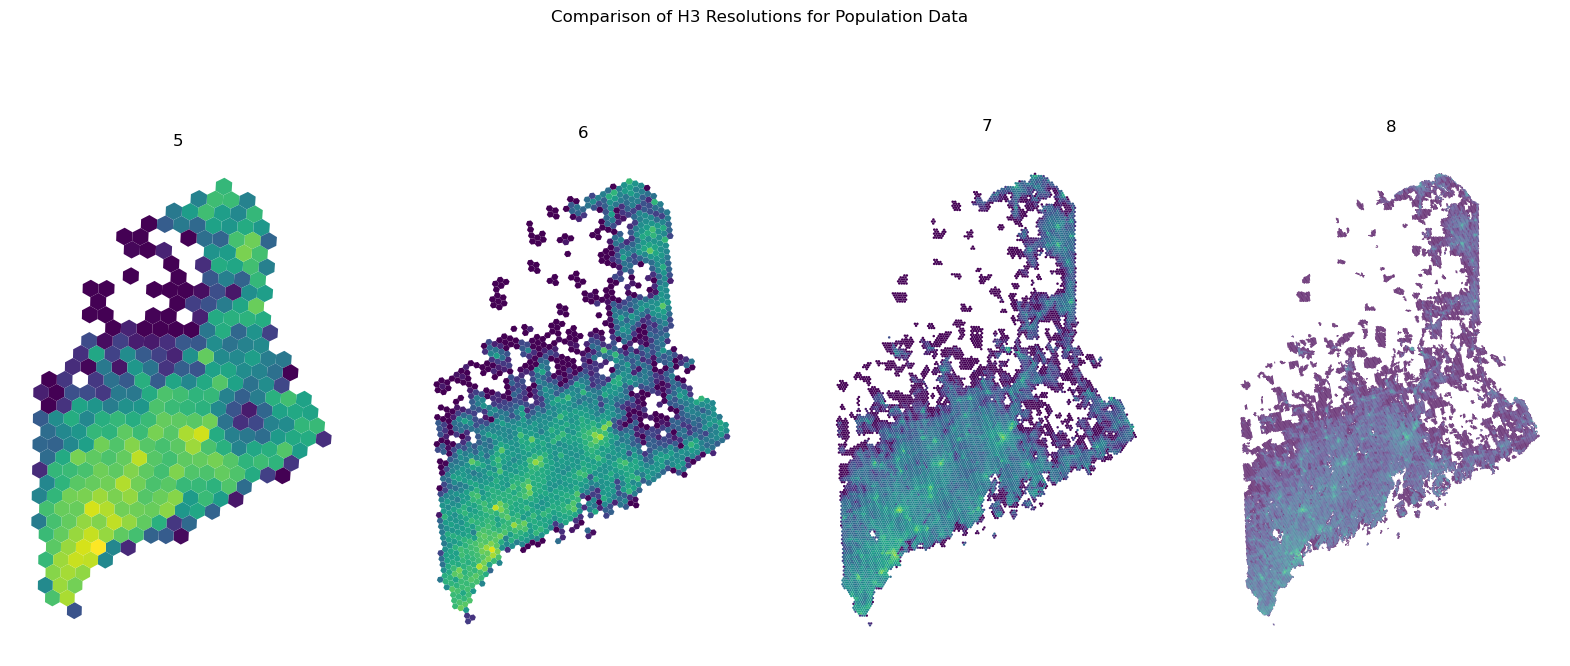

In [56]:
vmax = gdfs[0].population_fraction.max()
fig, axs = plt.subplots(1, len(dfs), figsize=(20,8))
for i, gdf in enumerate(gdfs):
    ax = axs[i]
    gdf.plot('population_fraction', ax=ax, norm=matplotlib.colors.LogNorm(vmin=1, vmax=vmax))
    ax.set_title(f"{resolutions[i]}")
    ax.axis("off")
fig.suptitle("Comparison of H3 Resolutions for Population Data")
